In [ ]:

function dₛ(ρ::Float64)
    α = π / 2 - 1 
    if ρ <= 1.0 && ρ >= 0.0
        return (1 - ρ) * (1 - α * ρ + (α * (2 * α - 1) )/ (2 * α + 1) * ρ^2)
    elseif ρ > 1.0
        throw(DomainError(ρ, "density must be < 1"))
        return 0.0
    elseif ρ < 0.0
        throw(DomainError(ρ, "density must be > 0"))
        return 0.0
    end
end
function dₛ_arr(rho_arr::Array{Float64})
    α = π / 2 - 1
    return (1 .- rho_arr) .* (1 .- α .* rho_arr .+ (α * (2 * α - 1) / (2 * α + 1)) .* rho_arr.^2)
end

function D(ρ::Float64)
    return (1 - dₛ(ρ)) / ρ
end

function s(ρ::Float64)
    return (1 - dₛ(ρ)) / ρ - 1
end
function s_arr(ρ::Array{Float64})
    return (1 .- dₛ_arr(ρ)) ./ ρ .- 1
end

function Q_diff(ρ₁::Float64, ρ₂::Float64)
    ρ = (ρ₁ + ρ₂) / 2.0
    α = π / 2.0 - 1.0
    β = (α * (2.0 * α - 1)) / (2.0 * α + 1.0)

    dQ_dρ = ((α + 1) - (α + β) * ρ + β * ρ^2) / dₛ(ρ)
    return dQ_dρ * (ρ₁ - ρ₂)
end
function Q_diff_arr(ρ₁::Array{Float64}, ρ₂::Array{Float64})
    ρ = (ρ₁ .+ ρ₂) ./ 2.0
    α = π / 2.0 - 1.0
    β = (α * (2.0 * α - 1)) / (2.0 * α + 1.0)

    dQ_dρ = ((α + 1) .- (α + β) .* ρ .+ β .* ρ.^2) ./ dₛ_arr(ρ)
    return dQ_dρ .* (ρ₁ .- ρ₂)
end



Q_diff_arr (generic function with 1 method)

In [2]:
@kwdef struct F
    Nₓ::Int
    Nᵩ::Int
    Lₓ::Float64
    Lᵩ::Float64 = 2 * π

    Δx::Float64
    Δθ::Float64

    Dₑ::Float64 = 1.0
    Dₒ::Float64 = 1.0
    v₀::Float64 = 20.0

    f::Array{Float64, 2}
    cos_term::Array{Float64} 
    V_diff::Array{Float64} 
end

function F(Nₓ::Int, Nᵩ::Int, Lₓ::Float64, f::Array{Float64, 2}, V::Function, v₀::Float64)
    Δx = Lₓ / Nₓ
    Δθ = 2 * π / Nᵩ

    V_arr_1 = V.(collect(0:Nₓ-2) .* Δx)
    V_arr_2 = V.(collect(1:Nₓ-1) .* Δx)
    V_diff = (V_arr_2 - V_arr_1) ./ Δx

    return F(
        Nₓ=Nₓ,
        Nᵩ=Nᵩ,
        Lₓ=Lₓ,
        Δx=Δx,
        Δθ=Δθ,
        f=f, 
        cos_term = repeat(cos.(collect(0:Nᵩ-1) .* Δθ)', Nₓ-1, 1),
        V_diff = V_diff, 
        v₀ = v₀
    )
end

function ρ(f::F)
    return (f.Lᵩ/f.Nᵩ) .* sum(f.f, dims=2)
end

function p1(f::F)
    e1 = cos.((0:f.Nᵩ-1) .* f.Δθ)
    return f.Δθ .* (f.f * e1)
end



p1 (generic function with 1 method)

In [14]:

function Uₓ(f::F)
    ρ_ = ρ(f)
    p1_ = p1(f)
    dₛ_ = dₛ_arr(ρ_)
    

    diffusion = diff(log.(f.f), dims=1) / f.Δx
    exclusion = repeat(Q_diff_arr(ρ_[2:end], ρ_[1:end-1]) ./ f.Δx, 1, f.Nᵩ)

    #TODO: add in potential term
    factor = (1 .- ρ_) ./dₛ_
    factor_avg = 0.5 .* (factor[1:end-1] .+ factor[2:end])
    potential = repeat((factor_avg .* f.V_diff), 1, f.Nᵩ)
    
    ps_dₛ = p1_ .* s_arr(ρ_) ./ dₛ_
    ps_dₛ_avg = 0.5 .* (ps_dₛ[1:end-1] .+ ps_dₛ[2:end])
    

    activity = ps_dₛ_avg .+ f.cos_term 
    return -f.Dₑ .* (diffusion .+ exclusion .+ potential) .+ f.v₀ .* activity
    #return -f.Dₑ .* (diffusion .+ exclusion) .+ f.v₀ .* activity
end

function Uᵩ(f::F)
    log_f = log.(f.f)
    diffusion = (circshift(log_f, (0, -1)) .- log_f) ./ f.Δθ
    return -f.Dₒ .* diffusion[1:end-1, :] 
end


Uᵩ (generic function with 1 method)

In [19]:
function Fₓ(f::F, Uₓ)
    ρ_ = ρ(f)
    
    dₛ_ = dₛ_arr(ρ_)
    dₛ_avg = 0.5 .* (dₛ_[1:end-1] .+ circshift(dₛ_, -1)[1:end-1])

    f_next = circshift(f.f, (-1, 0))[1:end-1, :]
    
    upwind_F = ifelse.(Uₓ .>= 0,
                       Uₓ .* f.f[1:end-1, :],
                       Uₓ .* f_next) .* dₛ_avg[:, :]
    
    return upwind_F
end

function Fᵩ(f::F, Uᵩ)
    return Uᵩ .* (f.f[1:end-1, :] .+ circshift(f.f, (0, -1))[1:end-1, :]) ./ 2
end

Fᵩ (generic function with 1 method)

In [24]:

function df_dt(f::F)
    U_x_ = Uₓ(f)
    U_theta_ = Uᵩ(f)

    aₓ = maximum(abs.(U_x_))
    aᵩ = maximum(abs.(U_theta_))

    F_x_ = Fₓ(f, U_x_)
    F_theta_ = Fᵩ(f, U_theta_)

    dFₓ_dx = -(F_x_[2:end, :] .- F_x_[1:end-1, :]) / f.Δx
    dFᵩ_dθ = -(F_theta_[2:end, :] .- circshift(F_theta_[2:end, :], (0, 1))) / f.Δθ
    df_dt_ = dFₓ_dx .+ dFᵩ_dθ

    return aₓ, aᵩ, df_dt_
end

function update!(f::F)
    f.f[1, :] .= f.f[end-1, :]
    f.f[end, :] .= f.f[2, :]

    aₓ, aᵩ, df_dt_ = df_dt(f)
    aₓ = aₓ == 0.0 ? 0.1 : aₓ
    aᵩ = aᵩ == 0.0 ? 0.1 : aᵩ

    Δt = minimum([f.Δx / (aₓ * 6), f.Δθ / (aᵩ * 6), 0.00005])

    f.f[2:end-1, :] .+= df_dt_ .* Δt
    return Δt
end

function evolve!(f::F, Nₜ::Int)
    t = 0.0
    history_rho = []  

    for n in 1:Nₜ
        if n % 100 == 0  
            push!(history_rho, vec(ρ(f)))  
        end
        Δt = update!(f) 
        t += Δt
    end

    history_rho = hcat(history_rho...)  

    return t, history_rho
end

function evolve_to_time!(f::F, T::Float64)
    t = 0.0
    counting_time = 0.0
    history_rho = []  

    while t <= T
        if counting_time >= 0.01 
            push!(history_rho, vec(ρ(f)))  
            counting_time = 0.0
        end
        Δt = update!(f)  
        t += Δt
        counting_time += Δt
    end

    history_rho = hcat(history_rho...)

    return t, history_rho
end




evolve_to_time! (generic function with 1 method)

In [7]:
function V(x)
    return 0.0
    #return 5*exp(-(x-1.5)^2 / (2*(0.05)^2))
end

V (generic function with 1 method)

In [25]:
Nₓ = 200
Nᵩ = 30

f_init = 1/(2*π) .* (0.6 .* ones(Nₓ, Nᵩ) + 0.01 .* rand(Nₓ, Nᵩ))
f = F(Nₓ, Nᵩ, 3.0, f_init, V, 20.0)

tᵢ = 5.0
t, history_rho = evolve_to_time!(f, tᵢ)

(5.000049999995016, [0.6050312595369883 0.6050551299549549 … 0.13189199067391197 0.1318935634555442; 0.605026659409243 0.60505097612536 … 0.12754849306631783 0.12755018423582037; … ; 0.6050314327762876 0.6050552199742267 … 0.13189199855115205 0.13189357122758394; 0.605026490516934 0.6050508804674044 … 0.1275484845977003 0.1275501758760999])

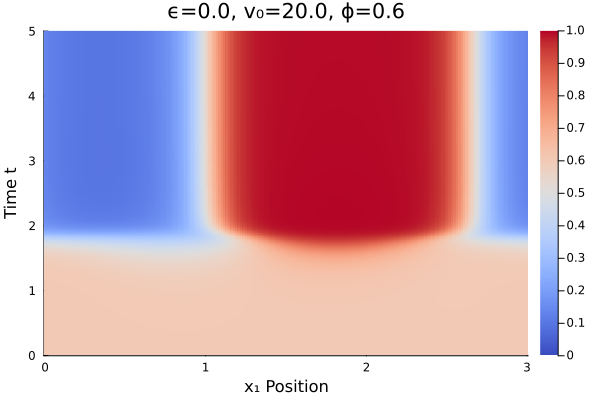

In [26]:
using Plots

# Plot the heatmap
n = 100  # Number of points along each axis
x = range(0, 3.0, length=size(history_rho)[1])
y = range(0, tᵢ, length=size(history_rho)[2])

heatmap(x, y, history_rho', color=:coolwarm, xlabel="x₁ Position", ylabel="Time t", title="ϵ=0.0, v₀=20.0, ϕ=0.6", clims=(0, 1))
